<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<font size="5"><b><center>Yandex Hackathon: Modelling by Team № 4</center></b></font>

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm, notebook

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import scipy
from scipy.sparse import csr_matrix
from statistics import mean

from catboost import CatBoostClassifier

import joblib
import faiss
from faiss import write_index

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

import warnings
import sys

warnings.filterwarnings("ignore")
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [ ]:
cwd = os.getcwd()

In [ ]:
cwd

In [2]:
PATH_TO_DF_FOR_CLASSIFIC = cwd + '/preprocessed_data/df_for_classific.csv'
PATH_TO_REC_PRED = cwd + '/preprocessed_data/prediction_rec_sys.csv'
PATH_TO_SPARSE_FOR_CLUSTER = cwd + '/preprocessed_data/sparse_cluster.npz'
PATH_TO_SPARSE_FOR_CLUSTER_TO_CLASSIF = cwd + '/preprocessed_data/sparse_cluster_to_classif.npz'

In [3]:
PATH_DATA = cwd + '/initial_data/data.csv'
PATH_SKU = cwd + '/initial_data/sku.csv'
PATH_SKU_CARGOTYPES = cwd + '/initial_data/sku_cargotypes.csv'

In [4]:
PATH_TO_SAVE_SCALER_CLASIFIC = cwd + '/for_docker_images/src/scalers/scaler_rb_for_clusific.bin'
PATH_TO_SCALER_FOR_CLUSTER = cwd + '/for_docker_images/src/scalers/scaler_rb_for_cluster.bin'
PATH_TO_SAVE_ENCODER = cwd + '/for_docker_images/src/scalers/encoder.bin'
PATH_TO_TFIDF_VECTORIZER = cwd + '/for_docker_images/src/vectorizers/tfidf_vectorizer.bin'

In [5]:
PATH_TO_SAVE_CLUSTERING_MODEL = cwd + "/for_docker_images/src/models/clustering_model.pkl"
PATH_TO_SAVE_FAISS = cwd + "/for_docker_images/src/models/fiass_index_with_drop_columns.index"
PATH_TO_SAVE_CLASSIF_MODEL = cwd + "/for_docker_images/src/models/rf_model.pkl"
PATH_TO_SAVE_COLUMNS_TO_DROP = cwd + "/for_docker_images/src/preprocessed_data/columns_to_drop"
PATH_TO_SAVE_COLUMNS_TARGET = cwd + "/for_docker_images/src/preprocessed_data/target.csv"

# Кластеризация

Одна из наших гипотез: **товары похожие по габаритным характеристикам и типам могут упаковываться в одну коробку**. Чтобы проверить эту гипотезу, нам необходимо построить модель группировки товаров. Для этого будет использовать обучение без учителя. Например, K-Means.

Загрузим ранее сохраненную матрицу для кластеризации. Она содержит линейные размеры товаров, их объём, преобразованные колонки при помощи tfidf, и булевые колонки есть ли у товара нулевые размеры и отсутствует ли карготип. 

In [6]:
def load_sparse_csr(filename: str):
    loader = np.load(filename)
    return scipy.sparse.csr_matrix((loader['data'],
                                    loader['indices'],
                                    loader['indptr']),
                                   shape=loader['shape'])

In [7]:
matrix_for_cluster = load_sparse_csr(PATH_TO_SPARSE_FOR_CLUSTER)

In [8]:
matrix_for_cluster = matrix_for_cluster.toarray()

##  PCA

Один из алгоритмов, который помогает визуализировать кластеры - PCA, или анализ главных компонент. Данный алгоритм позволяет уменьшить размерность данных, в результате которой похожие точки будут группироваться вместе. Посмотрим, можем ли мы увидеть кластеры без какой либо кластеризации.

In [9]:
%%time
pca = PCA(n_components=2)
pca_results = pca.fit_transform(matrix_for_cluster)
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])

CPU times: total: 3min 29s
Wall time: 30.1 s


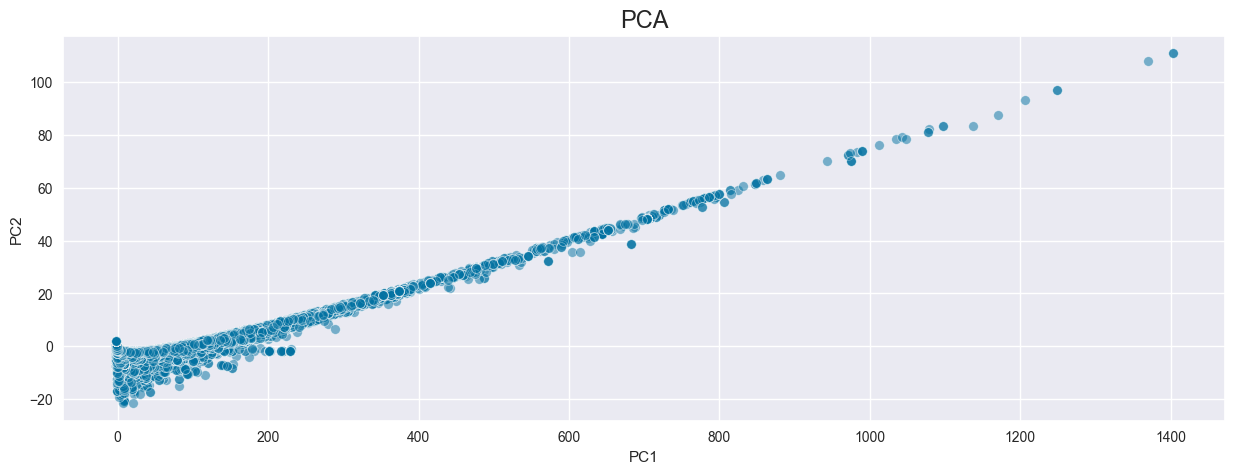

In [10]:
plt.figure(figsize=(15, 5))
sns.set_style('darkgrid')
plt.title('PCA', fontsize=17)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.5)
plt.grid(True); 

Все точки сливаются и между ними нет разделения. 3D график помог бы лучше исследовать распределени точек в пространстве, но, к сожалению, данную визуализацию построить не получилось.

Для группировки точек используем самый распространенный алгоритм кластеризации K-Means. Ему необходимо задать количество кластеров заранее, поэтому оптимизируем их количество с помощью метода локтя.

## K-Means

**Определим оптимальное количество кластеров с помощью метода локтя.**

Оптимальное количество кластеров - 7. Обучим модель на 7 кластерах и сделаем предсказания для визуализации.

In [11]:
%%time
kmeans = KMeans(n_clusters=7, random_state=42).fit(matrix_for_cluster)

CPU times: total: 20min 55s
Wall time: 2min 7s


In [12]:
kmeans_labels = kmeans.predict(matrix_for_cluster)

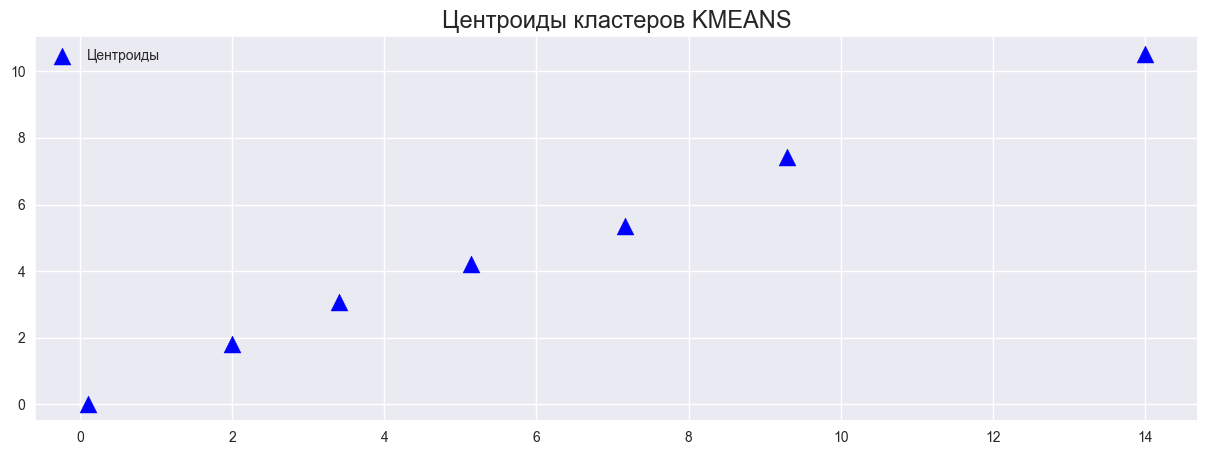

In [13]:
plt.figure(figsize=(15, 5))
sns.set_style('darkgrid')
plt.title('Центроиды кластеров KMEANS', fontsize=17)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s = 150,
            c = 'blue', marker = '^', label = 'Центроиды')
plt.legend()
plt.grid(True);

In [14]:
# добавим к PCA кластеры
pca_df['cluster'] = kmeans_labels

Окрасим точки в цвета кластеров.

<Figure size 1500x500 with 0 Axes>

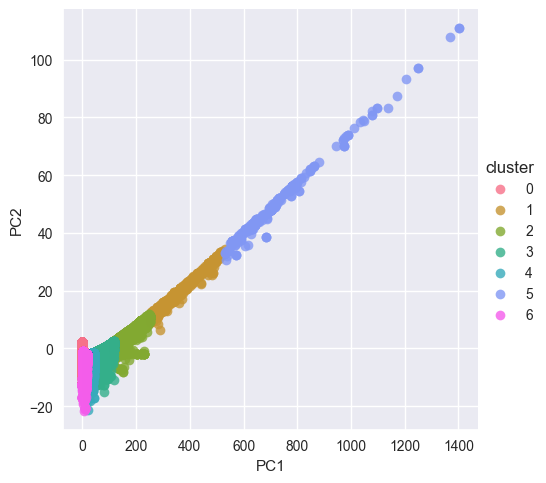

In [15]:
plt.figure(figsize=(15, 5))
sns.set_style('darkgrid')
sns.lmplot(data=pca_df, x='PC1', y='PC2', hue='cluster', fit_reg=False);

Посчитаем распределение точек по кластерам.

In [16]:
pca_df['cluster'].value_counts()

cluster
0    5773768
6     442292
4     128177
3      31445
2       7118
1       1233
5        258
Name: count, dtype: int64

Кластер 1 содержит самый больший процент точек, кластер 3 - наименьший.

Сохраним обученную модель кластеризации для дальнейшего использования.

In [17]:
pickle.dump(kmeans, open(PATH_TO_SAVE_CLUSTERING_MODEL, "wb"))

# Предсказание одного карготипа упаковки

**В кастве метрики для данной задачи выберем метрику recall(average='macro')**

**Посмотрим показатель текущей системы**

In [19]:
df_rec = pd.read_csv(PATH_TO_REC_PRED)

In [20]:
recall_score(df_rec['selected_carton'], 
             df_rec['recommended_cartontype'], 
             average='macro')

0.21073325392261902

**Будем считать текущее значение безлайном от которого будем отталкиваться**

**Откроем датасет для классификации**

In [21]:
df = pd.read_csv(PATH_TO_DF_FOR_CLASSIFIC)

In [22]:
df.shape

(81148, 96)

**В данный датасет необходимо добавить класетры товаров как признаки закодированные по принципу One-hot encoding. Для этого откроем подгоотовленный датасет для получения признаков с кластеризации**

In [23]:
matrix_for_predict = load_sparse_csr(PATH_TO_SPARSE_FOR_CLUSTER_TO_CLASSIF)

In [24]:
labels_for_df = kmeans.predict(matrix_for_predict)

In [25]:
df.shape

(81148, 96)

In [26]:
labels_for_df.size

81148

In [27]:
kmeans

KMeans(n_clusters=7, random_state=42)

In [28]:
np.unique(labels_for_df, return_counts=True)

(array([0, 1, 2, 3, 4, 6]),
 array([77246,     1,    14,    81,   408,  3398], dtype=int64))

In [29]:
labels_for_df

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
df['cluster'] = labels_for_df

In [31]:
df['cluster'].value_counts()

cluster
0    77246
6     3398
4      408
3       81
2       14
1        1
Name: count, dtype: int64

In [32]:
df['cluster'].unique()

array([0, 6, 4, 3, 2, 1])

In [33]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [34]:
ohe.fit(df['cluster'].values.reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [35]:
columns_for_ohe = ['cluster_' + str(i) for i in ohe.categories_[0]]

In [36]:
df[columns_for_ohe] = ohe.transform(df['cluster'].values.reshape(-1, 1)).toarray()
df.drop('cluster', axis=1, inplace=True)

In [37]:
df

,target,a,b,c,volume,no_size,10,1010,1011,110,...,990,no_cargotype,goods_wght,specific_weight,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_6
0,YMG,0.800000,0.627273,0.414286,1.094040,0,0.0,0.0,0.0,0.0,...,0.0,0,4.432258,1.280754,1.0,0.0,0.0,0.0,0.0,0.0
1,MYB,0.036364,-0.572727,-0.164286,-0.198518,0,0.0,0.0,0.0,0.0,...,0.0,0,-0.138710,0.524154,1.0,0.0,0.0,0.0,0.0,0.0
2,MYB,-0.218182,-0.300000,-0.157143,-0.176471,0,0.0,0.0,0.0,0.0,...,0.0,0,-0.325806,-0.241373,1.0,0.0,0.0,0.0,0.0,0.0
3,YMF,0.545455,-0.345455,-0.142857,0.008662,0,0.0,0.0,0.0,0.0,...,0.0,0,-0.091935,-0.118529,1.0,0.0,0.0,0.0,0.0,0.0
4,YMA,0.363636,-0.436364,-0.714286,-0.203722,0,0.0,0.0,0.0,0.0,...,0.0,0,0.080645,1.408797,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81143,MYA,0.000000,-0.163636,-0.714286,-0.200513,0,0.0,0.0,0.0,0.0,...,0.0,0,-0.322581,-0.151717,1.0,0.0,0.0,0.0,0.0,0.0
81144,MYC,-0.363636,-0.800000,0.357143,-0.288739,0,0.0,0.0,0.0,0.0,...,0.0,0,-0.322581,0.590009,1.0,0.0,0.0,0.0,0.0,0.0
81145,MYA,-0.545455,-0.618182,-0.642857,-0.325634,0,0.0,0.0,0.0,0.0,...,0.0,0,-0.322581,1.999901,1.0,0.0,0.0,0.0,0.0,0.0
81146,MYB,-0.181818,0.563636,-0.142857,0.054860,0,0.0,0.0,0.0,0.0,...,0.0,0,0.000000,-0.056191,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df.head()

,target,a,b,c,volume,no_size,10,1010,1011,110,...,990,no_cargotype,goods_wght,specific_weight,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_6
0,YMG,0.800000,0.627273,0.414286,1.094040,0,0.0,0.0,0.0,0.0,...,0.0,0,4.432258,1.280754,1.0,0.0,0.0,0.0,0.0,0.0
1,MYB,0.036364,-0.572727,-0.164286,-0.198518,0,0.0,0.0,0.0,0.0,...,0.0,0,-0.138710,0.524154,1.0,0.0,0.0,0.0,0.0,0.0
2,MYB,-0.218182,-0.300000,-0.157143,-0.176471,0,0.0,0.0,0.0,0.0,...,0.0,0,-0.325806,-0.241373,1.0,0.0,0.0,0.0,0.0,0.0
3,YMF,0.545455,-0.345455,-0.142857,0.008662,0,0.0,0.0,0.0,0.0,...,0.0,0,-0.091935,-0.118529,1.0,0.0,0.0,0.0,0.0,0.0
4,YMA,0.363636,-0.436364,-0.714286,-0.203722,0,0.0,0.0,0.0,0.0,...,0.0,0,0.080645,1.408797,1.0,0.0,0.0,0.0,0.0,0.0


**Датасет готов, теперь протестируем различные классификаторы, посмотрим какие они покажут метрики. Для начала выделим признаки и таргет, а также разделим выборку на обучающую и тестовую.**

In [39]:
X = df.drop('target', axis=1)
y = df['target']

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.3, stratify=y)

## Случайный лес

In [42]:
%%time
model_forest = RandomForestClassifier(random_state=123)
model_forest.fit(x_train, y_train)
predictions = model_forest.predict(x_test)
recall_score(y_test, predictions, average='macro')

CPU times: total: 15.5 s
Wall time: 15.5 s


0.21197854062409122

## SGD классифкатор

In [43]:
%%time
model_lin = SGDClassifier()
model_lin.fit(x_train, y_train)
predictions = model_lin.predict(x_test)
recall_score(y_test, predictions, average='macro')

CPU times: total: 2min 3s
Wall time: 2min 3s


0.05767446773347229

## CatBoost

In [44]:
%%time
model_cat = CatBoostClassifier(verbose=200, random_state=123)
model_cat.fit(x_train, y_train)
predictions = model_cat.predict(x_test)
recall_score(y_test, predictions, average='macro')

Learning rate set to 0.097229
0:	learn: 2.5555358	total: 246ms	remaining: 4m 5s
200:	learn: 1.6948501	total: 20s	remaining: 1m 19s
400:	learn: 1.6403236	total: 39.8s	remaining: 59.4s
600:	learn: 1.6031521	total: 59.5s	remaining: 39.5s
800:	learn: 1.5691216	total: 1m 19s	remaining: 19.7s
999:	learn: 1.5386019	total: 1m 39s	remaining: 0us
CPU times: total: 15min 14s
Wall time: 1min 39s


0.21219857250193563

In [45]:
del model_cat, model_forest, predictions, model_lin

**Поскольку CatBoostClassifier дал лучшие показатели метрики, то дальнейшие исследования будем произсодить именно на нём**

### Анализ влияния столбцов на качество модели

**Проверим как влияют параметры дата сета. Начнём с обучения на чиcтых карготипах.**

In [46]:
x_train.columns

Index(['a', 'b', 'c', 'volume', 'no_size', '10', '1010', '1011', '110', '120',
       ...
       '990', 'no_cargotype', 'goods_wght', 'specific_weight', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_6'],
      dtype='object', length=101)

In [47]:
columns_for_df = ['10', '1010', '1011', '110', '120', '130', '1300', '140', '160', '20',
       '200', '210', '290', '291', '292', '299', '300', '301', '302', '303',
       '305', '310', '315', '320', '330', '333', '340', '350', '360', '40',
       '400', '410', '440', '441', '460', '480', '485', '490', '510', '520',
       '600', '601', '610', '611', '620', '621', '622', '623', '640', '641',
       '670', '671', '672', '673', '690', '691', '692', '710', '720', '750',
       '751', '752', '760', '770', '780', '790', '799', '80', '801', '81',
       '900', '901', '905', '907', '908', '910', '911', '920', '930', '931',
       '950', '955', '960', '970', '980', '985', '990', 'no_cargotype']

In [48]:
%%time
model_cat = CatBoostClassifier(verbose=200, random_state=123)
model_cat.fit(x_train[columns_for_df], y_train)
predictions = model_cat.predict(x_test[columns_for_df])
recall_score(y_test, predictions, average='macro')

Learning rate set to 0.097229
0:	learn: 2.5935782	total: 92.3ms	remaining: 1m 32s
200:	learn: 1.8864084	total: 16.8s	remaining: 1m 6s
400:	learn: 1.8665677	total: 33.6s	remaining: 50.2s
600:	learn: 1.8562496	total: 50.4s	remaining: 33.4s
800:	learn: 1.8487920	total: 1m 7s	remaining: 16.7s
999:	learn: 1.8431473	total: 1m 23s	remaining: 0us
CPU times: total: 11min 47s
Wall time: 1min 24s


0.1584678560130578

In [49]:
del model_cat, predictions

**Как видим модель имеет значительно более низкую метрику, поскольку чисто карготипы не дают полной информации о характеристиках товара**.

**Добавим к датасету информацию о линейных размерах и объёмах (линейные размеры отсортированы так, что самым маленьким для всех товаров является размер 'a' самым большим размер 'c'**.

In [50]:
columns_for_df = columns_for_df + ['a', 'b', 'c', 'volume', 'no_size']

In [51]:
%%time
model_cat = CatBoostClassifier(verbose=200, random_state=123)
model_cat.fit(x_train[columns_for_df], y_train)
predictions = model_cat.predict(x_test[columns_for_df])
recall_score(y_test, predictions, average='macro')

Learning rate set to 0.097229
0:	learn: 2.5518908	total: 98ms	remaining: 1m 37s
200:	learn: 1.7160936	total: 18.6s	remaining: 1m 13s
400:	learn: 1.6679382	total: 37s	remaining: 55.3s
600:	learn: 1.6357941	total: 55.3s	remaining: 36.7s
800:	learn: 1.6075607	total: 1m 13s	remaining: 18.3s
999:	learn: 1.5813925	total: 1m 31s	remaining: 0us
CPU times: total: 13min 52s
Wall time: 1min 32s


0.20906996796320332

**Метрика стала лучше, однако её всё ещё можно улучшить. Добавим в датасет вес товара**.

In [52]:
columns_for_df = columns_for_df + ['goods_wght', 'specific_weight']

In [53]:
%%time
model_cat = CatBoostClassifier(verbose=200, random_state=123)
model_cat.fit(x_train[columns_for_df], y_train)
predictions = model_cat.predict(x_test[columns_for_df])
recall_score(y_test, predictions, average='macro')

Learning rate set to 0.097229
0:	learn: 2.5513168	total: 108ms	remaining: 1m 48s
200:	learn: 1.6968257	total: 19.7s	remaining: 1m 18s
400:	learn: 1.6415251	total: 39.6s	remaining: 59.2s
600:	learn: 1.6021654	total: 59.4s	remaining: 39.4s
800:	learn: 1.5692383	total: 1m 19s	remaining: 19.6s
999:	learn: 1.5378395	total: 1m 38s	remaining: 0us
CPU times: total: 14min 43s
Wall time: 1min 39s


0.21312571684554837

**Метрика стала ещё лучше. Можно сделать вывод, что для качественного предсказания модели хорошо подкодят карготипы зашифрованные в TfIdf, остортированные линейные размеры, рассчитанный объём, плотность и вес.**

**Проверим влияние кластров**

In [54]:
columns_for_df = columns_for_df + ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_6']

In [55]:
%%time
model_cat = CatBoostClassifier(verbose=200, random_state=123)
model_cat.fit(x_train[columns_for_df], y_train)
predictions = model_cat.predict(x_test[columns_for_df])
recall_score(y_test, predictions, average='macro')

Learning rate set to 0.097229
0:	learn: 2.5462191	total: 106ms	remaining: 1m 45s
200:	learn: 1.6938947	total: 20.2s	remaining: 1m 20s
400:	learn: 1.6412017	total: 39.9s	remaining: 59.6s
600:	learn: 1.6043008	total: 59.6s	remaining: 39.6s
800:	learn: 1.5707185	total: 1m 19s	remaining: 19.8s
999:	learn: 1.5401989	total: 1m 39s	remaining: 0us
CPU times: total: 15min 15s
Wall time: 1min 39s


0.2117116875109242

**Метрика стала ниже но не значительно**

### Выбор столбцов для обучения CatBoost по feature_importances

**Выберем столбцы оказывающие максимальное влияние на метрику, заведём их в датасет и посмотрим как они влияют на качество модели**

In [56]:
feature_importances = pd.DataFrame({'name': model_cat.feature_names_,
              'importances': model_cat.feature_importances_}).sort_values('importances', ascending=False)

In [57]:
feature_importances

,name,importances
90,c,15.329017
91,volume,12.033325
89,b,11.828418
93,goods_wght,11.784955
94,specific_weight,9.523550
...,...,...
67,80,0.000000
62,760,0.000000
61,752,0.000000
60,751,0.000000


**Построим график зависимости качества модели от порога отсечения значимости признака**

In [58]:
score_list = []
for i in tqdm(np.arange(0, 1.5, 0.1)):
    columns_importances = feature_importances[feature_importances['importances']>i]['name']
    model_cat = CatBoostClassifier(verbose=False)
    model_cat.fit(x_train[columns_importances], y_train)
    predictions = model_cat.predict(x_test[columns_importances])
    score_list.append(recall_score(y_test, predictions, average='macro'))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [18:56<00:00, 75.77s/it]


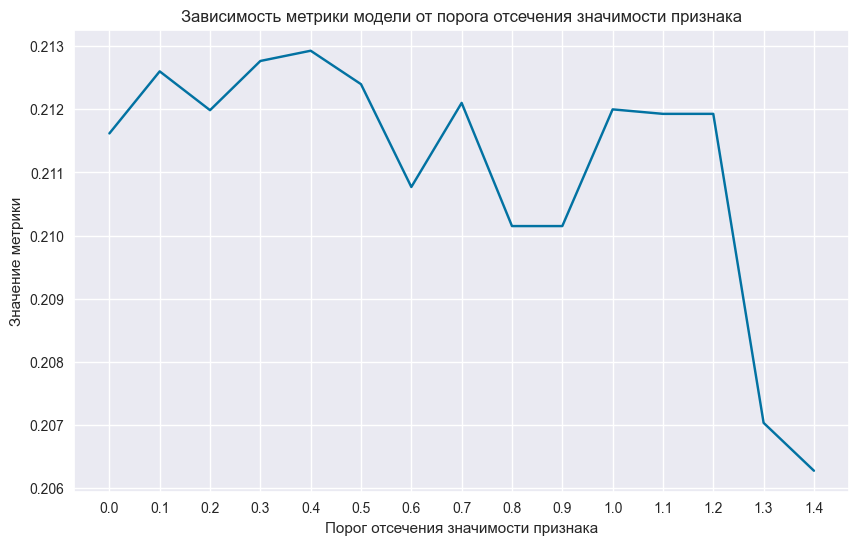

In [59]:
plt.figure(figsize=(10,6))
plt.title('Зависимость метрики модели от порога отсечения значимости признака')
plt.plot(np.arange(0, 1.5, 0.1), score_list)
plt.xlabel('Порог отсечения значимости признака')
plt.xticks(np.arange(0, 1.5, 0.1))
plt.ylabel('Значение метрики')
plt.grid('w')
plt.show()

**Из грфика видно, чтомаксимальное значения метрики можно получить при использованиии призаков с feature_importances_ больше 0,2**

**Обучим модель с такими признаками и посмотрим на качество модели**

In [60]:
columns_importances = feature_importances[feature_importances['importances']>0.4]['name']

In [61]:
columns_importances

90                  c
91             volume
89                  b
93         goods_wght
94    specific_weight
88                  a
12                290
26                340
54                690
10                200
59                750
21                310
80                950
31                410
55                691
64                780
28                360
37                490
40                600
35                480
32                440
58                720
33                441
39                520
56                692
48                640
82                960
71                901
Name: name, dtype: object

In [62]:
%%time
model_cat = CatBoostClassifier(verbose=200, random_state=123)
model_cat.fit(x_train[columns_importances], y_train)
predictions = model_cat.predict(x_test[columns_importances])
recall_score(y_test, predictions, average='macro')

Learning rate set to 0.097229
0:	learn: 2.5513754	total: 84.8ms	remaining: 1m 24s
200:	learn: 1.6905864	total: 16.4s	remaining: 1m 5s
400:	learn: 1.6295576	total: 32.4s	remaining: 48.4s
600:	learn: 1.5815835	total: 48.5s	remaining: 32.2s
800:	learn: 1.5423873	total: 1m 4s	remaining: 16s
999:	learn: 1.5039446	total: 1m 20s	remaining: 0us
CPU times: total: 11min 26s
Wall time: 1min 20s


0.21352832059156396

**Подберём гиперпараметры модели при помощи GridSearchCV**

In [ ]:
%%time
model_cat = CatBoostClassifier(verbose=False, random_state=123)
param = {'max_depth': range(5, 20, 5),
        'n_estimators': range(200, 1200, 200)}
cat_grid = GridSearchCV(model_cat, 
                        param,
                       scoring='f1_macro',
                       cv=3,
                       n_jobs=-1,
                       verbose=True)
cat_grid.fit(x_train[columns_importances], y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [113]:
print('Оптимальные параметры для модели CatBoostClassifier', cat_grid.best_params_)

Оптимальные параметры для модели CatBoostClassifier {'max_depth': 5, 'n_estimators': 1000}


In [114]:
print('Метрика для лучшего сочетания параметров модели CatBoostClassifier', cat_grid.best_score_)

Метрика для лучшего сочетания параметров модели CatBoostClassifier 0.20273051328522618


# Предсказание нескольких вариантов коробки

**В ходе анализа текущей системы, и мозгового штурма с командой дизайна было принято решение, что лучше возвращать не одну коробку а список из 3 наиболее подходящих коробок, чтобы у упоковщика, в случае необходимости была возможность выбора. Поэтому данная задача перешла в разряд рекомендательных систем. В связи с этим в качестве метрики была выбрана Recall@3, которая рассчитывает сколько раз хотя бы одна из рекомендованных упаковок в топ3 была правильно сматчена по отношению ко всем сделанным матчам**. 

**Её можно рассчитать по формуле:**

$$ Recall@3 =  {\sum найденных \space в \space топ3 \space матчей \over \sum матчей} $$

**Решать данную задачу будем при помощи Faiss, он позволит найти ближайший похожий товар и будем предполагать, что раз товары схожи, то и упаковки, вероятнее вего у них тоже будут схожими.**

**Создадим функцию, которая будет производить данный рассчёт**

In [41]:
def score_function(y_true, y_pred):
    metrick_list = []
    for i, y_p in enumerate(y_pred):
        metrick_list.append(1 if y_true[i] in y_p else 0)
    return mean(metrick_list)  

In [42]:
x_train = x_train.copy(deep = True)
x_test = x_test.copy(deep = True)

**Создадим словарь с ответами**

In [43]:
id_base_dict = dict(y_train.reset_index(drop=True))

**Чтобы ускорить рассчёт будем прогназировать не на всём тестовом датасете и исходя из этого будем подбирать параметры**

In [44]:
def x_train_predict_fias_n(x_train, x_test, y_test, k, n): #k- количество схожих товаров, n- количество элементов в тестовом df
    d = len(x_train.columns)
    nb = x_train.shape[0] 
    np.random.seed(123) 

    xb = x_train.values.astype('float32')
    xq_x_test = x_test.values.astype('float32')
    
    nlist = 1
    quantizer = faiss.IndexFlatIP(d)  
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    assert not index.is_trained
    index.train(xb)
    assert index.is_trained
    index.add(xb)
    
    x_test_n = x_test.iloc[:n]
    xq_x_test_n = xq_x_test[:n]
    y_test_n = y_test[:n].reset_index(drop=True)
        
    D, I = index.search(xq_x_test_n, k)
    predicted_list = []
    for candidates in I:
        predicted_list.append([id_base_dict[candidate] for candidate in candidates if candidate != -1])
    
    return score_function(y_test_n, predicted_list)

In [45]:
%%time
score_all = x_train_predict_fias_n(x_train, x_test, y_test, 3, 10_000)
print("Значение метрики на смаштабированном датасете со всеми столбцами равно", score_all)

Значение метрики на смаштабированном датасете со всеми столбцами равно 0.5595
CPU times: total: 57.7 s
Wall time: 5.62 s


**Проведём выбор признаков для Faiss. Определим какие признаки плохо влияют на метрику**.

In [46]:
column_drop = []
top_score = score_all
for col in tqdm(x_train.columns):
    column_drop.append(col)
    x_train_new = x_train.copy(deep=True)
    x_test_new = x_test.copy(deep=True)
    x_train_new = x_train_new.drop(column_drop, axis=1)
    x_test_new = x_test_new.drop(column_drop, axis=1)
    new_score = x_train_predict_fias_n(x_train_new, x_test_new, y_test, 3, 10_000)
    if top_score > new_score:
        column_drop.remove(col)
    else:
        top_score = new_score   

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [06:54<00:00,  4.10s/it]


In [47]:
print('Количество отсеяных признаков -', len(column_drop))

Количество отсеяных признаков - 45


In [48]:
column_drop

['volume',
 'no_size',
 '10',
 '130',
 '1300',
 '140',
 '160',
 '20',
 '210',
 '291',
 '299',
 '300',
 '302',
 '303',
 '310',
 '315',
 '333',
 '350',
 '400',
 '440',
 '485',
 '510',
 '600',
 '671',
 '751',
 '752',
 '760',
 '770',
 '790',
 '799',
 '80',
 '81',
 '900',
 '905',
 '907',
 '911',
 '930',
 '931',
 '970',
 '985',
 '990',
 'no_cargotype',
 'cluster_0',
 'cluster_1',
 'cluster_2']

In [49]:
with open(PATH_TO_SAVE_COLUMNS_TO_DROP, "wb") as file:
    pickle.dump(column_drop, file)

**Удалим столбцы, которые плохо влияют на метрику и посчитаем значение метрики без этих столбцов**.

In [50]:
x_drop_train = x_train[column_drop]
x_drop_test = x_test[column_drop]
x_train = x_train.drop(column_drop, axis=1)
x_test = x_test.drop(column_drop, axis=1)

In [51]:
%%time
score_all = x_train_predict_fias_n(x_train, x_test, y_test, 3, 10_000)
print("Значение метрики на смаштабированном датасете с отфильтрованными товарами равно", score_all)

Значение метрики на смаштабированном датасете с отфильтрованными товарами равно 0.5675
CPU times: total: 30.7 s
Wall time: 2.89 s


**Качество увеличилось не значительно, но время работы уменьшилось почти в 2 раза**

**Подберём количество предсказаний, которые нужно сделать, чтобы целевой признак точно попал в список**

In [52]:
list_train = [1,10,15] + list(range(20, 100, 10)) + list(range(100, 350, 50))

In [53]:
metric_list = []
for i in tqdm(list_train):
    score = x_train_predict_fias_n(x_train, x_test, y_test, i, 10_000)
    metric_list.append(score) 

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:48<00:00,  3.05s/it]


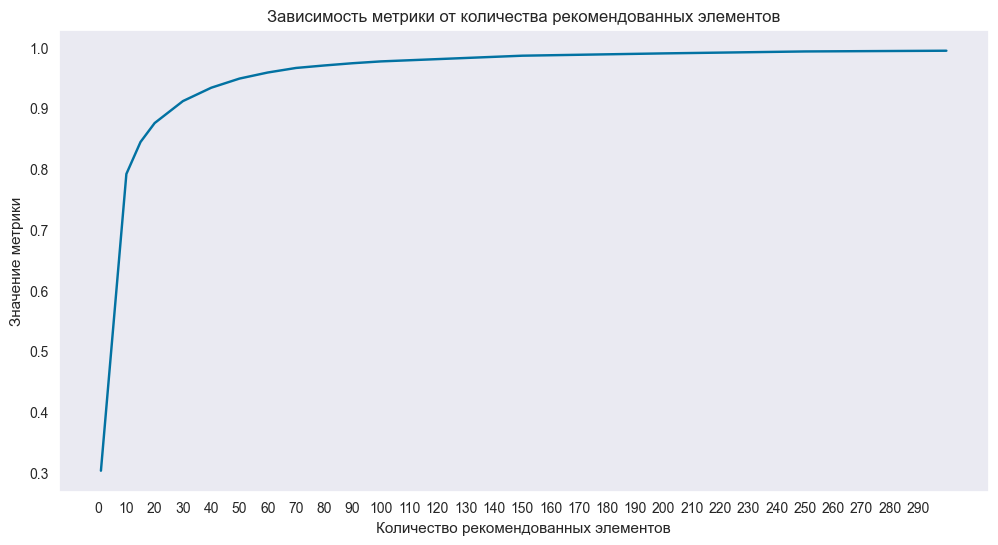

In [54]:
plt.figure(figsize=(12,6))
plt.title('Зависимость метрики от количества рекомендованных элементов')
plt.plot(list_train, metric_list)
plt.xlabel('Количество рекомендованных элементов')
plt.xticks(range(0, 300, 10))
plt.ylabel('Значение метрики')
plt.grid()
plt.show()

**По графику, можно предположить, что оптимально пытаться предсказать 100-150 схожих товаров, а потом обучить модель, которая будет выбирать 3 наиболее вероятные упаковки**.

**Однако, такой алгоритм предсказывает схожие товары, поэтому вполне может оказаться, что у первых n товаров одна и таже упаковка, а нам хотелось бы вернуть 3 разные, которые при этом подходят для товара. Решим данную задачу.**

**Напишим функцию для получения индекса рекомендованных k образцов**

In [55]:
def x_get_distance_indic(x_train, x_test, k, n=None):
    d = len(x_train.columns)
    nb = x_train.shape[0] 
    np.random.seed(123) 

    xb = x_train.values.astype('float32')
    xq_x_test = x_test.values.astype('float32')
    
    nlist = 1
    quantizer = faiss.IndexFlatIP(d)  
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    assert not index.is_trained
    index.train(xb)
    assert index.is_trained
    index.add(xb)
    
    if n != None:
        D, I = index.search(xq_x_test, k)
    else:
        xq_x_test_n = xq_x_test[:n]       
        D, I = index.search(xq_x_test_n, k)    
    return (D, I)

**Получим индекс для 100 ближайших товаров**

In [56]:
distance, ind = x_get_distance_indic(x_train, x_test, 100)

**Создадим функцию для получения 3 упаковок (поскольку ближайшие товары могут быть в одной и той же упаковке**.

In [57]:
# проверка на -1, чтобы не поймать ошибку (возникает в тех случаях, когда приходит товар с размерами равными нулю 
# и мы хотим вернуть ближайших соседей больше, чем есть таких товаров в индексе)
def get_list_predict_n(ind, n=3):
    predicted_list = []
    for candidates in ind:
        predict = []
        for candidate in candidates:             
            if (candidate != -1) and (id_base_dict[candidate] not in predict):        
                predict.append(id_base_dict[candidate])
        predicted_list.append(predict[:n])
    return predicted_list

In [58]:
score_function(y_test.reset_index(drop=True), get_list_predict_n(ind))

0.6383651673855001

**Как видим, не смотря на то, что были выбраны максимум 3 коробки для каждого товара, значение метрики возрасло. При этом необходимо найти границу, при которой дальнейшее увеличение предсказания ближайших товаров не оказывает сильного влияния на метрику.**

**Подберём оптимальное количество предсказанных товаров исходя из того, что выбирается 3 уникальные упаковки**.

In [59]:
list_train = [1, 3, 5, 7] + list(range(10, 70, 10))
metric_list = []
for i in tqdm(list_train):
    distance, ind = x_get_distance_indic(x_train, x_test, i)
    score = score_function(y_test.reset_index(drop=True), get_list_predict_n(ind))
    metric_list.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.85s/it]


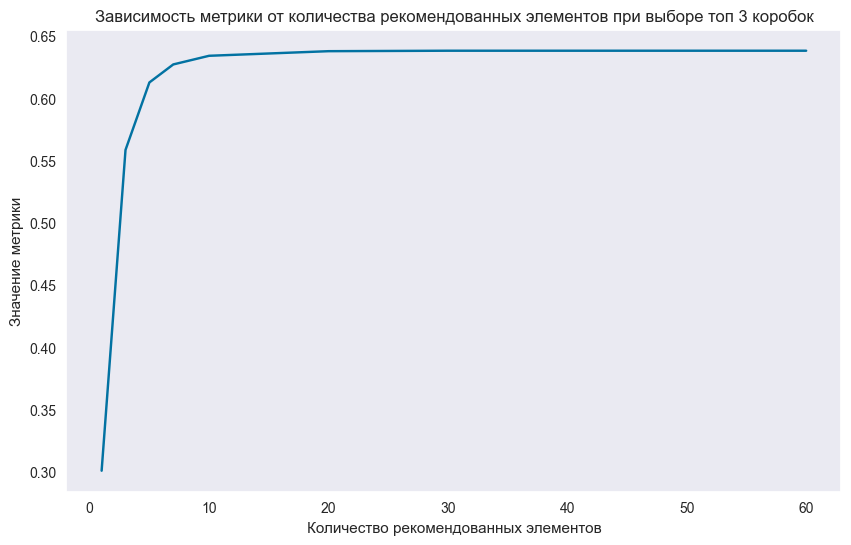

In [60]:
plt.figure(figsize=(10,6))
plt.title('Зависимость метрики от количества рекомендованных элементов при выборе топ 3 коробок')
plt.plot(list_train, metric_list)
plt.xlabel('Количество рекомендованных элементов')
plt.xticks(range(0, 70, 10))
plt.ylabel('Значение метрики')
plt.grid()
plt.show()

**Выведем табличный вариант данного датасета**.

In [61]:
pd.DataFrame({"Количество товаров": list_train,
             'Метрика': metric_list})

,Количество товаров,Метрика
0,1,0.301130
1,3,0.558718
2,5,0.612898
3,7,0.627357
4,10,0.634299
5,20,0.637995
6,30,0.638365
7,40,0.638365
8,50,0.638365
9,60,0.638365


**Из данных видно, что после 20 скорость возрастания метрики значительно замедляется, при этом время нахождения ближайших соседей будет увеличиваться. Поэтому выберем в качестве границы количество ближайших товаров (k) равное 20.**

**Обучим индекс faiss на оптимальных параметрах**.

In [62]:
distance, ind = x_get_distance_indic(x_train, x_test, 20)

# Создание алгоритма формирования заказов в минимальное количество упаковок

**Создадим функцию, которая возвращает индекс faiss**

In [63]:
def x_get_index(x_train):
    d = len(x_train.columns)
    nb = x_train.shape[0] 
    np.random.seed(123) 

    xb = x_train.values.astype('float32')
    
    nlist = 1
    quantizer = faiss.IndexFlatIP(d)  
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    assert not index.is_trained
    index.train(xb)
    assert index.is_trained
    index.add(xb)   
    return index

In [64]:
ind = x_get_index(x_train)

**Создадим функцию, которая на вход будет принимать индекс фаиса, датасет, по окторому нужно предсказать, а возвращать будет список из n элементов. Так же добавим параметр one_row, который будет указывать, что на проверку подаётся датасет из одной строки и нужно вернуть не массив списков, а одну запись.**

In [65]:
def get_fit_predict_list_n(index, x_test, k=20, n=3, one_row=True):
    
    xq_x_test = x_test.values.astype('float32')
    dem, ind = index.search(xq_x_test, k)
    
    predicted_list = []    
    for candidates in ind:
        predict = []
        for candidate in candidates:
            if id_base_dict[candidate] not in predict:        
                predict.append(id_base_dict[candidate])
        predicted_list.append(predict[:n])
    if one_row:
        return list(np.array(predicted_list).reshape(-1, ))
    return predicted_list

**Создадим тестовый датасет Из текущих данных (то как будут приходить данные после получения ордера и класстеризации)**

In [66]:
df_data = pd.read_csv(PATH_DATA, index_col=0)
df_sku = pd.read_csv(PATH_SKU, index_col=0)
df_sku_cargotype = pd.read_csv(PATH_SKU_CARGOTYPES, index_col=0)

**Воспользуемся функцией из препроцессинга для создания списка карготипов для каждой sku**

In [67]:
def forming_df_for_tfidf(df_in):
    df = df_in.copy(deep=True)
    df['cargotype'] = df['cargotype'].astype('str')
    df_for_tfidf = df[['sku', 'cargotype']]
    df_for_tfidf['cargotype'] = df_for_tfidf['cargotype'] + ' '
    df_for_tfidf = df_for_tfidf.groupby('sku')['cargotype'].agg('sum').reset_index(drop=False)
    return df_for_tfidf

In [68]:
df_sku_cargot_str = forming_df_for_tfidf(df_sku_cargotype)

**Выберем 10 слуайных строк из датасета и присоединим все необходимые столбцы из других датасетов**

In [228]:
np.random.seed(456)
sku_in_order = np.random.randint(0, 10_000, 10)
df_order = df_data.loc[sku_in_order][['sku', 'goods_wght']].merge(df_sku, how='left', on='sku')
df_order = df_order.merge(df_sku_cargot_str, how='left', on='sku')
df_order.head(5)

,sku,goods_wght,a,b,c,cargotype
0,f1a7b29b05b742b9f1b47aed3a6ef8cd,0.139,9.4,3.6,6.8,290 340 440 441 460 480 520 690
1,0bdaa1fb0836b5c6e2b0f0a6458e11fc,0.070,18.0,3.0,10.0,290
2,ff9a04886f13a9fb3f587be06de5bf58,1.350,50.0,15.0,40.0,291 600 610 950 960 970 980
3,6ff34ff7477d0a1b43ea2d81dfcb6fa9,0.130,18.0,6.0,4.0,290 340 410 720 750 780 960
4,9bc9efa4c735620cd13820a64fee10b5,1.017,11.3,6.1,20.3,290 320 340 410 750 780


**Продублируем случайные товары в заказе 10 раз**

In [229]:
np.random.seed(456)
for i in range(10):
    number_of_row = np.random.randint(0, df_order.shape[0], 1)
    df_order.loc[len(df_order.index)] = df_order.loc[number_of_row].values.reshape(-1,)

In [230]:
df_order

,sku,goods_wght,a,b,c,cargotype
0,f1a7b29b05b742b9f1b47aed3a6ef8cd,0.139,9.4,3.6,6.8,290 340 440 441 460 480 520 690
1,0bdaa1fb0836b5c6e2b0f0a6458e11fc,0.070,18.0,3.0,10.0,290
2,ff9a04886f13a9fb3f587be06de5bf58,1.350,50.0,15.0,40.0,291 600 610 950 960 970 980
3,6ff34ff7477d0a1b43ea2d81dfcb6fa9,0.130,18.0,6.0,4.0,290 340 410 720 750 780 960
4,9bc9efa4c735620cd13820a64fee10b5,1.017,11.3,6.1,20.3,290 320 340 410 750 780
5,7f88115c2fcb08ec45843216a3f8766b,1.514,20.7,9.6,29.9,120 290 340 690 770 780 801 1010
6,36c524a241808e5bf7bc27e4d2dee52e,0.003,8.0,15.0,0.1,290 320 330
7,cf5e7e23f15b6f1f2cf562d54421df2f,4.900,14.0,35.0,14.0,290 340 670 690
8,9ae2ee1d488294794a8a553b54b136d7,0.410,19.0,5.0,13.0,290 320 360 410 750 780 1011
9,f67952d3c114cd1c96f99cff5f1ab74b,1.050,8.0,26.0,8.0,290 410 520 720 750


**Воспользуемся функцией из препроцессинга для сортировки размерностей sku**

In [231]:
def sorted_dementions_sku(df):
    df['list_demensions'] = df.apply(lambda x: sorted([x['a'], x['b'], x['c']]), axis=1)
    df['a'] = df.apply(lambda x: x['list_demensions'][0], axis=1)
    df['b'] = df.apply(lambda x: x['list_demensions'][1], axis=1)
    df['c'] = df.apply(lambda x: x['list_demensions'][2], axis=1)
    
    df.drop('list_demensions', axis=1, inplace=True)
    return df

In [232]:
df_order = sorted_dementions_sku(df_order)

**Загрузим обученный tf_idf и scaker, для преобразоавния параметров. Индекс из фаиса уже обучен (ind), столбцы для дропа определены (column_drop)**

In [233]:
scaler_clasific = joblib.load(PATH_TO_SAVE_SCALER_CLASIFIC)
scaler_claster = joblib.load(PATH_TO_SCALER_FOR_CLUSTER)
tfidf = joblib.load(PATH_TO_TFIDF_VECTORIZER)

**Добвим функцию для преобразования карготайпов в tfidf**

In [234]:
def get_tfidf_dataframe(df, tfidf):
    tfidf_matrix = tfidf.transform(df['cargotype'])
    dict_for_columns = {i[1]:i[0] for i in tfidf.vocabulary_.items()}
    new_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix).rename(columns=dict_for_columns)    
    new_df.insert(0, 'sku', df['sku'])    
    new_df['no_cargotype'] = (df['cargotype']=='').astype('int')
    return new_df

**Создадим датасет для предсказания кластера. Для начала преобразуем карготипы**

In [235]:
def get_df_for_cluster(df, tfidf, scaler):
    new_df = df.copy(deep=True)
    df_cargotype = get_tfidf_dataframe(new_df[['sku', 'cargotype']], tfidf)   
    new_df = new_df[['sku', 'a', 'b', 'c']]
    new_df['volume'] = new_df['a'] * new_df['b'] * new_df['c']
    new_df = new_df.merge(df_cargotype.drop_duplicates(), how='left', on='sku')   
    new_df['no_cargotype'] = (df['cargotype']=='').astype('int')   
    new_df['no_size'] = ((new_df['a'].values==0) & 
                         (new_df['b'].values==0) & 
                         (new_df['c'].values==0)).astype('int')
    new_df[['a', 'b', 'c', 'volume']] = scaler.transform(new_df[['a', 'b', 'c', 'volume']])
    new_df.drop(['sku'], axis=1, inplace=True)
    return new_df

In [236]:
df_for_claster = get_df_for_cluster(df_order, tfidf, scaler_claster)

**Добавим столбец обозначающий кластер от 0 до 6**

In [237]:
df_order['cluster'] = kmeans.predict(df_for_claster)
df_order.head()

,sku,goods_wght,a,b,c,cargotype,cluster
0,f1a7b29b05b742b9f1b47aed3a6ef8cd,0.139,3.6,6.8,9.4,290 340 440 441 460 480 520 690,0
1,0bdaa1fb0836b5c6e2b0f0a6458e11fc,0.070,3.0,10.0,18.0,290,0
2,ff9a04886f13a9fb3f587be06de5bf58,1.350,15.0,40.0,50.0,291 600 610 950 960 970 980,6
3,6ff34ff7477d0a1b43ea2d81dfcb6fa9,0.130,4.0,6.0,18.0,290 340 410 720 750 780 960,0
4,9bc9efa4c735620cd13820a64fee10b5,1.017,6.1,11.3,20.3,290 320 340 410 750 780,0


**Добавим функцию для обработки весо-габаритных характеристик**

In [238]:
def get_weight_size_charact (df):   
    new_df = df.copy(deep=True)
    
    new_df['specific_weight'] = new_df['goods_wght'] / new_df['volume']
    new_df['specific_weight'] = new_df['specific_weight'].fillna(0)
    new_df.loc[new_df['specific_weight']==np.inf, 'specific_weight'] = sys.maxsize
    
    new_df = new_df.fillna(0)
    return new_df

**Создадим функцию производящую полное преобразование входящего датасета**

In [239]:
def get_df_for_predict(df, tfidf, scaler, column_drop):
    new_df = df[['sku', 'a', 'b', 'c', 'cluster']]
    new_df['volume'] = new_df['a'] * new_df['b'] * new_df['c']
    new_df['no_size'] = ((df['a'].values==0) & 
                         (df['b'].values==0) & 
                         (df['c'].values==0)).astype('int')
    new_df = sorted_dementions_sku(new_df)
    
    df_tfidf = get_tfidf_dataframe(df[['sku', 'cargotype']], tfidf)
    new_df = new_df.merge(df_tfidf, how='left', on='sku')
    
    new_df['goods_wght'] = df['goods_wght']
    new_df = get_weight_size_charact (new_df)
    new_df[['a', 'b', 'c', 'volume', 'goods_wght', 'specific_weight']] = scaler.transform(
                                    new_df[['a', 'b', 'c', 'volume', 'goods_wght', 'specific_weight']])
    
    new_df[columns_for_ohe] = ohe.transform(new_df['cluster'].values.reshape(-1, 1)).toarray()
    new_df.drop('cluster', axis=1, inplace=True)
    
    new_df = new_df.drop(column_drop, axis=1)
    new_df = new_df.drop('sku', axis=1)
    return new_df

**Поскольку нам потребуется отсекать крупногаборитный товар, либо те случаи, кода предложенное сочетание товаров, приводит к тому, что алгоритм прогназирует ему упаковку как для крупногабаритного, то создадим список упаковок для таких товаров и напишим функцию, которая будет сравнивать два списка (список упаковок для крупногабаритных товаров и прогноз)**

In [240]:
#Создадим список упаковок для крупногабаритных товаров
LIST_BIG_CARTON = ['STRETCH', 'NONPACK']

In [241]:
def get_bool_list_ib_list(list1, list2):
    res = False
    for carton in list1:
            if carton in list2:
                res = True
    return res

**Создадим алгоритм, который будет группровать товары и прогназировать для них упаковку. Распишим принцип работы алгоритма:**
* **Алгоритм на вход получает таблицу с основными весо-габаритными характеристиками товара, списком карготайпов и предсказанным кластером;**
* **Создаём словарь в который будет добавлен результат прогноза;**
* **Разбиваем товары согласно кластерам (поскольку считаем, что товары в разных кластерах значительно отличаются, а значит их лучше не объединять в одной упаковке);**
* **Сортируем товары по объёму от большего к меньшему и начинаем их перебирать. В процессе перебора для каждого товара выполняем следующие операции:**    
    * **Проеобразуем товар в формат для предсказания в faiss и делаем прогноз упаковок;**
    * **Проверям, если товар пришёл для прогноза один, то добавляем прогноз в словарь, прерываем цикл и возвращаем результат;**
    * **Если товар пришёл не один проверяем, не крупногабаритный ли он. Если крупногабаритный, то доабавляем результат в словарь и идём на следующую итерацию цикла;**
    * **Если товар не крупногабаритный, то создаём список с sku товаров (добавляем рассматриваемый товар в него) и начинаем перебирать оставшиеся товары последовательно совершая следующие действия:**
        * **Создания супер-айтема в виде существующего товара;**
        * **Объединение супер-айтема с новым товаром по принципу:** 
            - **сложение минимального габарита (размер а);**
            - **попарный выбор максимального габарита по двум оставшися размерам (b и c);**
            - **сложения веса;**
            - **объединение карготайпов и составления списка уникальных занчений;**
            - **предобработка нового суперайтема и приведение к виду для прогноза в faiss;**
        * **Прогнозирование упаковки в faiss;**
        * **Проверяем не стал ли товар крупногабаритным, если стал, то берём следующий товар из запроса;**
        * **Если товар не стал крупногабаритным, то:**
            - **делаем текущим товаром наш суперайтем, чтобы в следующей итерации уже его обрабатывать как текущий айтем;**
            - **добавляем в список товаров товар из данной итерации;**
            - **добавляем в список индексов индекс данного товара;**
    * **После того, как были перебраны все товары в данном кластере, добавляем объединённые товары (те, что попали в суппер-айтем и были упакованы) в словарь для финального ответа. Значением в словаре является рпрогноз упаковок для данного суперайтема;**
    * **Удаляем индексы по списку выше и сбрасываем значение индексов;**
* **Переходим к следующей итерации товаров, пока список не укажется пустым.**

In [242]:
#Cловарь с sku товаров
dict_sku = {}
# перебираем кластеры по очереди
for cluster in sorted(df_order['cluster'].unique()):
    df_cluster = df_order[df_order['cluster']==cluster]
    #Отсортируем df_cluster по объёму
    df_cluster['volume'] = df_cluster['a'] * df_cluster['b'] * df_cluster['c'] 
    df_cluster = df_cluster.sort_values('volume', ascending=False)
    df_cluster = df_cluster.drop('volume', axis=1)
    
    # сбросим индексы
    df_cluster = df_cluster.reset_index(drop=True)    
    
    #Создадим словарь с текущей стопкой sku товаров
    list_sku = []
    

    while df_cluster.shape[0] != 0:
        index_for_drop = [0] # для записи индексов товаров, которые упакованы
        # делаем текущим айтемом первую строку, добавляем её в текцщий список sku
        item = df_cluster.iloc[:1]  
        old_item = item.copy(deep=True)
        
        list_sku.append(item.loc[0]['sku'])
        # проводим предобработку sku в формат для предсказания и делаем прогноз
        item = get_df_for_predict(item, tfidf, scaler_clasific, column_drop) 
        predict = get_fit_predict_list_n(ind, item)

        #Проверяем не один ли товар в ордере, если один, то предиктим, добавляем в словарь, и выходим из цикла
        if df_cluster.shape[0] == 1:
            dict_sku[' '.join(map(str, list_sku))] = predict
            break
        #Проверяем не был ли товар крупногабаритным по упаковке, если был, то просто добавляем в словарь и дропаем его из датасета
        if get_bool_list_ib_list(LIST_BIG_CARTON, predict):
            dict_sku[' '.join(map(str, list_sku))] = predict
            df_cluster = df_cluster[df_cluster.index != 0]
            df_cluster = df_cluster.reset_index(drop=True)
            list_sku = []
        else:  
            # если товар не был крупногабаритным, то перебираем все оставшиеся товары, чтобы доукомплектовать коробку
            for i in range(1, df_cluster.shape[0]):

                # Выбираем наименьший размер текущего айтема и доавляем кнему наименьший размер следующего   
                new_item = df_cluster.iloc[i:i+1]
                new_item_sku = new_item.loc[i]['sku']
                new_item['a'] = old_item['a'].values + new_item['a'].values
                # после этого переопределяем наибольший размер по оставшимся двум измерениям
                new_item['b'] = max(old_item['b'].values, new_item['b'].values)
                new_item['c'] = max(old_item['c'].values, new_item['c'].values)
                
                # определяем вес объединенного айтема
                new_item['goods_wght'] = old_item['goods_wght'].values + new_item['goods_wght'].values

                # определяем новый карготип товара, для этого объединяем карготипы двух рассматриваемых товаров,
                # разделяем их в список, находим уникальные вхождения при помощи множеств, объединяем обратно в строку
                new_item['cargotype'] = ' '.join(set((old_item.loc[0]['cargotype'] + new_item.loc[i]['cargotype']).split()))                
                # проводим предобработку sku в формат для предсказания и делаем прогноз
                item_for_pred = get_df_for_predict(new_item.reset_index(drop=True), tfidf, scaler_clasific, column_drop)                
                predict_list = get_fit_predict_list_n(ind, item_for_pred)
                #если новый товар не крупногабаритный, тогда добавляем его в список супер товара 
                #и дропаем второй товар из df_cluster               
                if  not get_bool_list_ib_list(LIST_BIG_CARTON, predict_list):
                    list_sku.append(new_item_sku)
                    index_for_drop.append(i)
                    old_item = new_item.reset_index(drop=True)                 
                    
            #удаляем объект, обнуляем индексы               
            df_cluster = df_cluster[~df_cluster.index.isin(index_for_drop)]
            df_cluster = df_cluster.reset_index(drop=True)
            old_item_for_pred = get_df_for_predict(old_item, tfidf, scaler_clasific, column_drop)
            #После обхода добавляем в словарь очередной набор
            dict_sku[' '.join(map(str, list_sku))] = get_fit_predict_list_n(ind, old_item_for_pred) 
            list_sku = []

Ответ на запрос

In [243]:
dict_sku

{'cf5e7e23f15b6f1f2cf562d54421df2f': ['NONPACK', 'STRETCH', 'YMW'],
 '7f88115c2fcb08ec45843216a3f8766b': ['NONPACK', 'YMW', 'YMG'],
 'f67952d3c114cd1c96f99cff5f1ab74b f67952d3c114cd1c96f99cff5f1ab74b 9bc9efa4c735620cd13820a64fee10b5 6ff34ff7477d0a1b43ea2d81dfcb6fa9': ['YMF',
  'YMC',
  'YME'],
 '9bc9efa4c735620cd13820a64fee10b5 9ae2ee1d488294794a8a553b54b136d7 36c524a241808e5bf7bc27e4d2dee52e': ['YMF',
  'YMG',
  'YMW'],
 '0bdaa1fb0836b5c6e2b0f0a6458e11fc': ['YMX', 'MYB', 'MYC'],
 'f1a7b29b05b742b9f1b47aed3a6ef8cd': ['MYC', 'YMA', 'MYB'],
 'ff9a04886f13a9fb3f587be06de5bf58': ['STRETCH', 'MYE', 'NONPACK']}

# Выводы

В данном разделе были рассмотрены четыре поставленные задачи задачи:
    1. Задача группировки товара.
    2. Задача поиска одной коробки, которая подходит для заданных параметров
    3. Задача поиска нескольких коробок, которые могут подойти для заданных параметров (рекомендательная система для упаковщика)
    4. Задача разработка алгоритма, который позволяет группировать товары и подбирать для группы товаров три наиболее подходящие варианта упаковки.

В ходе работы над первой задачей сделано:

    1. Проанализированы данные и выбран оптимальный алгоритм кластеризации
    2. Выбраны наилучшие гиперпараметры параметры для алгоритма (количество кластеров)
    
В ходе работы над второй задачей сделано:

    1. Выбрана метрика для данного типа задачи: recall(average='macro')
    2. Проанализирован ряд моделей, лучшее качество показала модель CatBoostClassifier.
    3. Проанализированы признаки для обучения моделей, было установлено, что помимо линейных размеров на качество модели оказывают влияние также объём, вес и карготипы товара (для данной модели их преобразовывали при помощи TfIdf). Также было установлено, что для использование признаков с feature_importances больше 0,4 позволяет немного увеличить качество модели.
   
В ходе работы над третьей задачей сделано:

    1. Выбрана метрика для подобного типа задач в виде Recall@3
    2. Выбрана модель faiss, поскольку позволяет предскзать требуемое количество схожих соседей, но работает быстрее чем knn
    3. Проанализированы признаки, которые подаются на вход модели, было установлено, что около 45 признаков карготипа являются избыточными и неготивно сказываются на качестве модели, при этом их удаление ускорило скорость работы модели почти в два раза (эти признаки объединены в список column_drop).
    4. Разарботана функция, которая выбирает топ 3 упаковки для каждого товара (поскольку у нескольких ближайших товаров упаковка может освпадать). При этом данная функция может вернуть и меньшее количество упаковок, если у всех ближайших соседей будет одна и та же упаковка.
    5. Подобрано оптимальное количество ближайших товаров, которые необходимо предсказать, чтобы получить максимальны прирост в качестве, но при этом не сликом утяжелить модель (в данной задаче параметр k оказался равен 20).
    
В ходе работы над четвертоё задачей сделано:

    1. Разработан процесс подготовки сырых данных (как они будут приходить на вход) в тот вид, котрый будет обрабатывать модель.
    2. Предложен алгоритм, который обрабатывает поданные товары по кластерам. Суть алгоритма заключается в том, что товары первоначально отсортированные по кластерам группируются друг с другом начиная от товара с самым большим объёмом к товару с самым малым объёмом до тех пор, пока алгоритм предсказания упаковки не выдаст рекомндацию упаковывать товар как крупногабаритный (упаковки типа 'STRETCH' или 'NONPACK'). Когда алгоритм выдаёт такой прогноз, то берётся последний нормалдьный вариант и используется в качестве наиболее подходящего.
    3. Использование данного алгоритма позволила в тестовом прогоне упаковать заказ из 20 случайных товаров в 7 упаковок (при этом две позиции являлись крупногабаритным товаром и не могли быть сгруппированы с другими.